In [1]:
import numpy as np
import pandas as pd
from numpy.lib.stride_tricks import as_strided

In [2]:
daily_df = pd.read_parquet(r"D:\stock_prop_shop\.all\data\price_data\daily\daily_data.parquet")

In [3]:
daily_df = daily_df.drop_duplicates(subset=['date', 'order_book_id'])

In [4]:
def rolling_window(a, window):
    """
    创建一个滚动窗口视图。
    
    参数:
    a : ndarray
        输入数组。
    window : int
        窗口大小。
    
    返回:
    result : ndarray
        具有滚动窗口视图的数组。
    """
    a = a.values
    shape = a.shape[:-1] + (a.shape[-1] - window + 1, window)
    strides = a.strides + (a.strides[-1],)
    return as_strided(a, shape=shape, strides=strides)

def convert_values(x):
    if pd.isnull(x):  # 如果值是空值，返回空值
        return x
    if x < 10:
        return -1
    elif x >= 10:
        return 1
    else:
        return x  # 如果值等于10，保持不变

In [5]:
daily_df["money_per_trd"] = daily_df["total_turnover"] / daily_df["num_trades"]
daily_df["ret_pct"] = daily_df.groupby("order_book_id")["close"].pct_change()

In [6]:
mpt_df = pd.pivot(daily_df, index="date", columns="order_book_id", values="money_per_trd")
ret_pct_df = pd.pivot(daily_df, index="date", columns="order_book_id", values="ret_pct")

In [7]:
ftr_dict = {}
for i in mpt_df.columns:
    mpt_data = pd.DataFrame(rolling_window(mpt_df[i], 20))
    pct_data = pd.DataFrame(rolling_window(ret_pct_df[i], 20))
    mpt_data = mpt_data.rank(axis=1).applymap(convert_values)
    ftr_data = (pct_data *  mpt_data).sum(axis=1)
    ftr_dict[i] = ftr_data

In [8]:
alpha_006 = pd.DataFrame(ftr_dict)
alpha_006.index = ret_pct_df.index[19:]
alpha_006.to_parquet("./alpha_006.parquet")
alpha_006 = alpha_006.shift(1)

In [9]:
close_df = pd.pivot(daily_df, index="date", columns="order_book_id", values="close")
open_df = pd.pivot(daily_df, index="date", columns="order_book_id", values="open")

In [10]:
daily_df["money_per_trd"] = daily_df["total_turnover"] / daily_df["num_trades"]
daily_df["ret_pct"] = daily_df.groupby("order_book_id")["close"].pct_change()

In [11]:
long_mom = (close_df / open_df -1).rolling(250).sum().shift(1)

In [12]:
long_mom.to_parquet("./long_mom.parquet")

In [13]:
import performance as perf
import utils 
import tears
import plotting

In [14]:
ftr_stack = utils.get_clean_factor_and_forward_returns(alpha_006, close_df, quantiles=10, periods=(5,10,20))

Dropped 16.8% entries from factor data: 16.8% in forward returns computation and 0.0% in binning phase (set max_loss=0 to see potentially suppressed Exceptions).
max_loss is 35.0%, not exceeded: OK!


Information Analysis


,5D,10D,20D
IC Mean,-0.052,-0.062,-0.074
IC Std.,0.080,0.084,0.086
IC_IR,-0.646,-0.729,-0.869
t-stat(IC),-22.868,-25.835,-30.769
p-value(IC),0.000,0.000,0.000
IC Skew,0.206,0.634,0.599
IC Kurtosis,0.442,2.224,1.129


c:\Users\41979\Desktop\assignment\utils.py:923: UserWarning: Skipping return periods that aren't exact multiples of days.
  warnings.warn(


Turnover Analysis


,5D,10D,20D
Quantile 1 Mean Turnover,0.604,0.768,0.889
Quantile 2 Mean Turnover,0.779,0.841,0.890
Quantile 3 Mean Turnover,0.806,0.847,0.877
Quantile 4 Mean Turnover,0.827,0.864,0.882
Quantile 5 Mean Turnover,0.844,0.875,0.890
Quantile 6 Mean Turnover,0.845,0.877,0.892
Quantile 7 Mean Turnover,0.837,0.875,0.895
Quantile 8 Mean Turnover,0.814,0.861,0.893
Quantile 9 Mean Turnover,0.754,0.827,0.879
Quantile 10 Mean Turnover,0.484,0.632,0.793


,5D,10D,20D
Mean Factor Rank Autocorrelation,0.607,0.365,0.09


<Figure size 640x480 with 0 Axes>

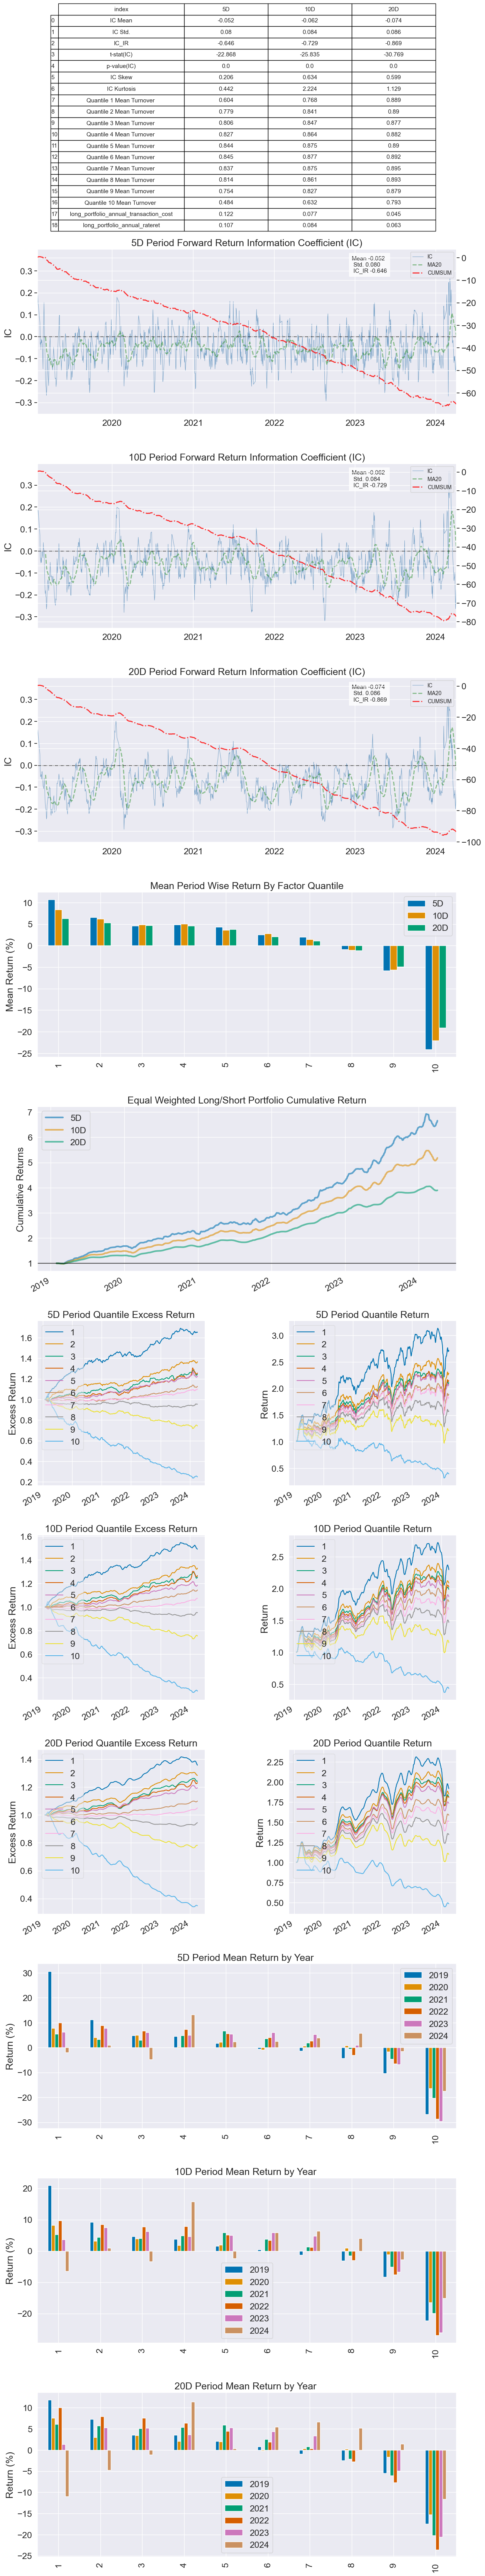

In [15]:
tears.create_summary_tear_sheet(ftr_stack, file_path ="./alpha_006/")

In [16]:
alpha_001 = pd.read_parquet(r"C:\Users\41979\Desktop\assignment\fundamental_ftr1\factor_data.parquet").stack()
alpha_002 = pd.read_parquet(r"C:\Users\41979\Desktop\assignment\inday_mom\factor_data.parquet").stack()
alpha_003 = pd.read_parquet(r"C:\Users\41979\Desktop\assignment\long_mom\factor_data.parquet").stack()
alpha_004 = pd.read_parquet(r"C:\Users\41979\Desktop\assignment\mom_skew\factor_data.parquet").stack()
alpha_005 = pd.read_parquet(r"C:\Users\41979\Desktop\assignment\overnight_mom\factor_data.parquet").stack()

In [19]:
alpha_001 = pd.read_parquet(r"C:\Users\41979\Desktop\assignment\fundamental_ftr1\factor_data.parquet").stack()
alpha_002 = pd.read_parquet(r"C:\Users\41979\Desktop\assignment\inday_mom\factor_data.parquet").stack()
alpha_006 = pd.read_parquet(r"C:\Users\41979\Desktop\assignment\alpha_006\factor_data.parquet").stack()

In [20]:
alpha_data = pd.concat([alpha_001, alpha_002, alpha_006], axis=1)

In [21]:
alpha_data.corr()

,0,1,2
0,1.000000,-0.003067,-0.003064
1,-0.003067,1.000000,0.641488
2,-0.003064,0.641488,1.000000
